In [1]:
!pip install torchsummary --quiet
!pip install rising
!pip install gdown
!pip install torchmetrics==0.10.0 --quiet

In [2]:
!nvidia-smi

Tue Nov 12 18:15:11 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip show accelerate

Name: accelerate
Version: 0.34.2
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.10/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [4]:
import os
import torch
import torchvision
# import torchfunc
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchsummary import summary
# from torch.cuda import amp

import random
import nibabel as nib

import timm


import copy
from sklearn.metrics import classification_report, confusion_matrix

import tarfile

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn.metrics import f1_score

from tqdm import tqdm
import wandb

from glob import glob

import cv2 
import time
from datetime import timedelta, datetime
import gdown
from PIL import Image
import PIL
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


# Accelerate parts
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from accelerate.utils import set_seed # reproducability across devices

In [5]:
SEED_VAL = 7
N_CLASSES_main = 1
N_CLASSES_js = 30



def seed_everything(seed: int):
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True
    
seed_everything(SEED_VAL)

order = torch.randint(low = 1, 
                      high = 31,
                      size = ()) 
print(order.item())


16


In [6]:
!wandb login 9bcca10ca9e53a56c143feea922812a4d99a5dd7

wandb_run = wandb.init(project = f'image_deraining_baseline',
                       name = f'trail_{datetime.now()}')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: vish-tej99 (vish-tej99-fairleigh-dickinson-university). Use `wandb login --relogin` to force relogin


In [7]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
torch.tensor(float('inf')).item()

inf

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
print(device)

cuda


In [10]:
class Custom_dataset_RainDS(Dataset):
    def __init__(self, 
                 base_folder_path: str,
                 transforms = None,
                 mode: str = "train"):
        self.base_folder_path = base_folder_path
        self.transforms = transforms
        self.mode = mode
        
        fPath_GT = os.path.join(base_folder_path, "gt")
        fPath_rdrop = os.path.join(base_folder_path, "raindrop")
        fPath_rstreak= os.path.join(base_folder_path, "rainstreak")
        fPath_rdrop_rstreak= os.path.join(base_folder_path, "rainstreak_raindrop")
        
        files_list_GT = glob(os.path.join(fPath_GT, "*.png"))
        files_list_rdrop = glob(os.path.join(fPath_rdrop, "*.png"))
        files_list_rstreak = glob(os.path.join(fPath_rstreak, "*.png"))
        files_list_rdrop_rstreak = glob(os.path.join(fPath_rdrop_rstreak, "*.png"))
        
        files_list_GT.sort()
        files_list_rdrop.sort()
        files_list_rstreak.sort()
        files_list_rdrop_rstreak.sort()
        
        self.data = []
        print(len(files_list_GT), len(files_list_rdrop), len(files_list_rstreak), len(files_list_rdrop_rstreak))
        
        for fname_GT, fname_rdrop in tqdm(zip(files_list_GT, files_list_rdrop)):
            self.data.append([fname_GT, fname_rdrop])
        
        for fname_GT, fname_rstreak in tqdm(zip(files_list_GT, files_list_rstreak)):
            self.data.append([fname_GT, fname_rstreak])
        
        for fname_GT, fname_rdrop_rstreak in tqdm(zip(files_list_GT, files_list_rdrop_rstreak)):
            self.data.append([fname_GT, fname_rdrop_rstreak])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        fname_GT, fname_rain = self.data[idx]
        img_GT = cv2.imread(fname_GT) 
        img_GT = cv2.cvtColor(img_GT, cv2.COLOR_BGR2RGB)
        img_rain = cv2.imread(fname_rain) 
        img_rain = cv2.cvtColor(img_rain, cv2.COLOR_BGR2RGB)
        
        if self.transforms:
            img_GT = self.transforms(img_GT)
            img_rain = self.transforms(img_rain)
            
        return {"img_rain": img_rain,
                "img_GT": img_GT}
        

In [11]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
def get_dataloaders():
    
    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
        transforms.Resize((224, 224), interpolation=PIL.Image.BILINEAR)
    ])

    train_ds =  Custom_dataset_RainDS(base_folder_path = "/kaggle/input/rainds/RainDS/RainDS_real/train_set", 
                                      transforms = image_transforms,
                                      mode = "train")

    test_ds =  Custom_dataset_RainDS(base_folder_path = "/kaggle/input/rainds/RainDS/RainDS_real/test_set", 
                                      transforms = image_transforms,
                                      mode = "test")

    train_dl = DataLoader(train_ds, 
                          batch_size=32,
                          shuffle=True, 
                          num_workers=4)

    valid_dl = DataLoader(test_ds, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=4)

    test_dl = DataLoader(test_ds, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=4)

    print(train_ds.__len__())
    return train_dl, valid_dl, test_dl
train_dl, valid_dl, test_dl = get_dataloaders()

150 150 150 150


150it [00:00, 353850.17it/s]
150it [00:00, 278753.04it/s]
150it [00:00, 430332.15it/s]


98 98 98 98


98it [00:00, 149415.41it/s]
98it [00:00, 153088.19it/s]
98it [00:00, 147963.21it/s]

450


tensor(1.0000) tensor(-0.9894)
torch.Size([32, 3, 224, 224]) torch.Size([32, 3, 224, 224])


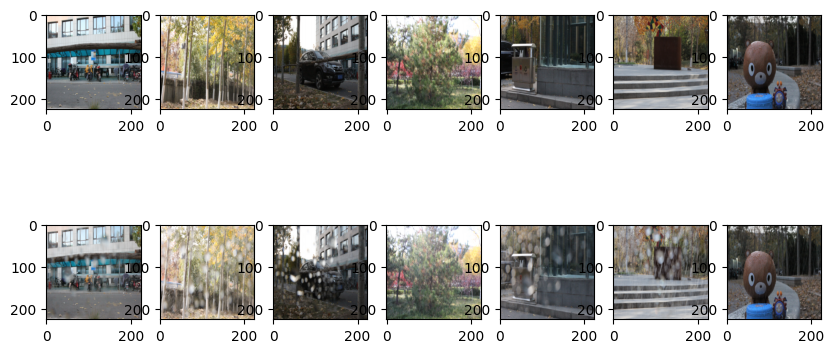

In [12]:
# files_list = glob("//kaggle/input/rainds/RainDS/RainDS_real/train_set/gt/*.png")
# print(len(files_list))
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

for batch in train_dl:
    batch_GT, batch_rain = batch["img_GT"], batch["img_rain"]
    print(batch_GT.max(), batch_GT.min())
    print(batch["img_GT"].shape, batch["img_rain"].shape)
    batch_GT = denormalize(batch_GT, *stats)
    batch_rain = denormalize(batch_rain, *stats)
    # img_GT, img_rain = batch_GT[0].permute(1,2,0), batch_rain[0].permute(1,2,0)
    f, axarr = plt.subplots(2,7, figsize = (10,5))
    for i in range(7):
        axarr[0,i].imshow(batch_GT[i].permute(1,2,0))
        axarr[1,i].imshow(batch_rain[i].permute(1,2,0),)
#     f.tickparams(left = False, bottom = False)
    break

In [13]:
# files_list = glob("/kaggle/input/gt-rain/GT-RAIN_train-001/GT-RAIN_train/**/*.png")
# print(len(files_list))

In [14]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [15]:
# model = UNet(num_classes = 3)
# dummy_input = torch.rand(batch_GT.size())
# out = model(dummy_input)
# print(dummy_input.size(), out.size())

In [16]:
from torch.autograd import Variable
from torchmetrics.classification import Accuracy, BinaryAccuracy

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

EPS = 1e-8
        
def PSNR_compute(input, target):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)

def MSE_compute(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])

In [17]:
# testing = PSNR_compute(dummy_input, dummy_input)
# print(testing.shape)

In [18]:
from sklearn.metrics import accuracy_score

def train_epoch(epoch,
                data_loader, 
                model, 
                criterion_1,
                optimizer, 
                accelerator):
    accelerator.print(f'\n\ntrain at epoch {epoch}')
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses_all = AverageMeter()
    
    all_outputs = torch.tensor([]).to(accelerator.device)
    all_targets = torch.tensor([]).to(accelerator.device)
    
    end_time = time.time()
    for batch in tqdm(data_loader, disable=(not accelerator.is_local_main_process)):
        inputs, targets = batch['img_rain'], batch['img_GT']
        data_time.update(time.time() - end_time)
        
        outputs = model(inputs)
        loss_mse = criterion_1(outputs, targets)
        
        loss = loss_mse

        losses_all.update(loss.data, inputs.size(0))
        
        # Accelerate will handle the mixed precision and backwards pass for you
        accelerator.backward(loss)

        optimizer.step()
        optimizer.zero_grad()
        
        predictions = outputs
        # When calculating metrics we need to *gather* all of the tensors across devices
        # and drop the padded extra inputs added for efficiency (consistant batch size across devices)
        predictions, targets = accelerator.gather_for_metrics((
                predictions, targets
            ))
        
        all_targets = torch.cat((all_targets, targets), dim = 0)
        all_outputs = torch.cat((all_outputs, predictions), dim = 0)
        
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        
    accelerator.wait_for_everyone()
    mse_val = torch.mean(MSE_compute(all_outputs, all_targets))
    psnr_val = torch.mean(PSNR_compute(all_outputs, all_targets))
    accelerator.print(f"train MSE : {mse_val:.4f}")
    accelerator.print(f"train PSNR: {psnr_val:.4f}")
    return mse_val, psnr_val

def evaluate_model(data_loader, 
                   model,
                   criterion_1,
                   accelerator):
    model.eval()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses_all = AverageMeter()
    
    all_outputs = torch.tensor([]).to(accelerator.device)
    all_targets = torch.tensor([]).to(accelerator.device)
    end_time = time.time()
    for batch in tqdm(data_loader,disable=(not accelerator.is_local_main_process)):
        inputs, targets = batch['img_rain'], batch['img_GT']
        data_time.update(time.time() - end_time)

        with torch.no_grad():
#             inputs = inputs.cuda()
#             targets = targets.cuda()
            
            outputs = model(inputs)
            loss_mse = criterion_1(outputs, targets)
        
            loss = loss_mse

            losses_all.update(loss.data, inputs.size(0))

            predictions = outputs
            
            # When calculating metrics we need to *gather* all of the tensors across devices
            # and drop the padded extra inputs added for efficiency (consistant batch size across devices)
            predictions, targets = accelerator.gather_for_metrics((predictions, 
                                                                   targets
            ))
        
            all_targets = torch.cat((all_targets, targets), dim = 0)
            all_outputs = torch.cat((all_outputs, predictions), dim = 0)
        
        batch_time.update(time.time() - end_time)
        end_time = time.time()
    
    accelerator.wait_for_everyone()
    mse_val = torch.mean(MSE_compute(all_outputs, all_targets))
    psnr_val = torch.mean(PSNR_compute(all_outputs, all_targets))
    accelerator.print(f"valid MSE : {mse_val:.4f}")
    accelerator.print(f"valid PSNR: {psnr_val:.4f}")
    return mse_val, psnr_val

In [19]:
import warnings
warnings.filterwarnings('ignore')

# criterion = nn.CrossEntropyLoss()



def training_loop(num_epochs:int=2, 
                  mixed_precision:str='fp16', 
                  seed:int=42, 
                  batch_size = 16):
    
    # criterion_cls1 = nn.CrossEntropyLoss()
    num_epochs = num_epochs

    # Set our seed
    set_seed(seed) #ThalaForAReason

    # Initialize the Accelerator, our main interface
    # it will handle mixed precision automatically for us
    accelerator = Accelerator(mixed_precision=mixed_precision)
    
    criterion_1 = nn.MSELoss()
    
    train_dl, valid_dl, test_dl = get_dataloaders()

#     acc = BinaryAccuracy().to(accelerator.device)
    device = get_default_device()
    print("DEVICE: ",device)

    # Instantiate the model here so the seed controls new weight initalization
    # We should only download one copy of the model, and then load from the cache:
    with accelerator.main_process_first():
        model = UNet(num_classes = 3)

    # Instantiate the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), 
                                 lr=1e-3)

    model, optimizer, train_dl, valid_dl = accelerator.prepare(
                                model, 
                                optimizer, 
                                train_dl, 
                                valid_dl, 
        )

    train_MSE_list, train_PSNR_list = [], []
    valid_MSE_list, valid_PSNR_list = [], []

    best_val_loss,  epoch_of_interest = 10000, None
    for i in range(num_epochs):
    #             adjust_learning_rate(optimizer, i, opt)
        accelerator.print(f"######################### Epoch : {i:04d} ##########################")
        print_flag = False
        ep_start_time = time.time()
        train_MSE, train_PSNR = train_epoch(i, 
                                            train_dl, 
                                            model, 
                                            criterion_1, 
                                            optimizer, 
                                            accelerator)
        
        valid_MSE, valid_PSNR = evaluate_model(valid_dl, 
                                           model, 
                                           criterion_1, 
                                           accelerator)

        train_MSE_list.append(train_MSE)
        train_PSNR_list.append(train_PSNR)
        valid_MSE_list.append(valid_MSE)
        valid_PSNR_list.append(valid_PSNR)
        
        wandb_run.log({"train_MSE": train_MSE,
                   "train_PSNR": train_PSNR,
                   "valid_MSE": valid_MSE,
                   "valid_PSNR": valid_PSNR})
        
        if(valid_MSE < best_val_loss):
            best_val_loss = train_MSE
            epoch_of_interest = i
            
        ep_total_time = time.time() - ep_start_time
        accelerator.print(str(timedelta(seconds=ep_total_time)))
        accelerator.print("#####"*20)
        
#         accelerator.wait_for_everyone()
    print(f"Epoch of interest: {epoch_of_interest}")

    # To save the model afterwards to use for inference we first wait for all of the processes to be aligned
    accelerator.wait_for_everyone() 

    # Then we unwrap the model from any distributed wrapping that was performed
    model = accelerator.unwrap_model(model)

    # and Acceleate can then save the model once (as all workers have the same model with the same weights now)
    save_fname = "image_deraining_v3"
    torch.save(model.state_dict(), f"/kaggle/working/{save_fname}.pt")

In [20]:
notebook_launcher(training_loop, 
                  (15, "fp16", 42, 16), 
                  num_processes=1)

Launching training on one GPU.
150 150 150 150


150it [00:00, 170500.16it/s]
150it [00:00, 268750.79it/s]
150it [00:00, 174957.06it/s]


98 98 98 98


98it [00:00, 98335.36it/s]
98it [00:00, 144326.47it/s]
98it [00:00, 262478.79it/s]

450
DEVICE:  cuda


######################### Epoch : 0000 ##########################


train at epoch 0


100%|██████████| 15/15 [00:18<00:00,  1.27s/it]


train MSE : 0.1906
train PSNR: 8.8753


100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


valid MSE : 11.4628
valid PSNR: -10.4222
0:00:31.004407
####################################################################################################
######################### Epoch : 0001 ##########################


train at epoch 1


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


train MSE : 0.0767
train PSNR: 11.8921


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


valid MSE : 0.1506
valid PSNR: 8.5593
0:00:30.762481
####################################################################################################
######################### Epoch : 0002 ##########################


train at epoch 2


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


train MSE : 0.0593
train PSNR: 13.1719


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


valid MSE : 0.1002
valid PSNR: 10.6744
0:00:30.601490
####################################################################################################
######################### Epoch : 0003 ##########################


train at epoch 3


100%|██████████| 15/15 [00:18<00:00,  1.24s/it]


train MSE : 0.0515
train PSNR: 13.8329


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


valid MSE : 0.0723
valid PSNR: 13.3688
0:00:30.519942
####################################################################################################
######################### Epoch : 0004 ##########################


train at epoch 4


100%|██████████| 15/15 [00:18<00:00,  1.26s/it]


train MSE : 0.0410
train PSNR: 14.8028


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


valid MSE : 0.0659
valid PSNR: 13.8958
0:00:30.778051
####################################################################################################
######################### Epoch : 0005 ##########################


train at epoch 5


100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


train MSE : 0.0350
train PSNR: 15.4841


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


valid MSE : 0.0644
valid PSNR: 14.1453
0:00:31.225441
####################################################################################################
######################### Epoch : 0006 ##########################


train at epoch 6


100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


train MSE : 0.0338
train PSNR: 15.6032


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


valid MSE : 0.0686
valid PSNR: 14.0031
0:00:30.825352
####################################################################################################
######################### Epoch : 0007 ##########################


train at epoch 7


100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


train MSE : 0.0329
train PSNR: 15.7435


100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


valid MSE : 0.0623
valid PSNR: 14.2168
0:00:31.045106
####################################################################################################
######################### Epoch : 0008 ##########################


train at epoch 8


100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


train MSE : 0.0314
train PSNR: 15.8913


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


valid MSE : 0.0730
valid PSNR: 13.9540
0:00:31.107889
####################################################################################################
######################### Epoch : 0009 ##########################


train at epoch 9


100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


train MSE : 0.0318
train PSNR: 15.9180


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


valid MSE : 0.0699
valid PSNR: 14.1552
0:00:31.368405
####################################################################################################
######################### Epoch : 0010 ##########################


train at epoch 10


100%|██████████| 15/15 [00:19<00:00,  1.27s/it]


train MSE : 0.0315
train PSNR: 15.9711


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


valid MSE : 0.1301
valid PSNR: 11.2209
0:00:31.037379
####################################################################################################
######################### Epoch : 0011 ##########################


train at epoch 11


100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


train MSE : 0.0332
train PSNR: 15.7188


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


valid MSE : 0.0597
valid PSNR: 14.9529
0:00:31.223288
####################################################################################################
######################### Epoch : 0012 ##########################


train at epoch 12


100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


train MSE : 0.0278
train PSNR: 16.4534


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


valid MSE : 0.0661
valid PSNR: 14.1092
0:00:30.975001
####################################################################################################
######################### Epoch : 0013 ##########################


train at epoch 13


100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


train MSE : 0.0266
train PSNR: 16.6622


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


valid MSE : 0.0640
valid PSNR: 14.6952
0:00:30.874637
####################################################################################################
######################### Epoch : 0014 ##########################


train at epoch 14


100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


train MSE : 0.0268
train PSNR: 16.6539


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


valid MSE : 0.0597
valid PSNR: 14.5410
0:00:30.991953
####################################################################################################
Epoch of interest: 3


In [21]:
wandb_run.finish()

train_MSE,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
train_PSNR,▁▄▅▅▆▇▇▇▇▇▇▇███
valid_MSE,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_PSNR,▁▆▇███████▇████
train_MSE,0.0268
train_PSNR,16.65386
valid_MSE,0.05973
valid_PSNR,14.54103


In [22]:
model2 = torch.load("/kaggle/working/image_deraining_v1.pt").to('cpu')

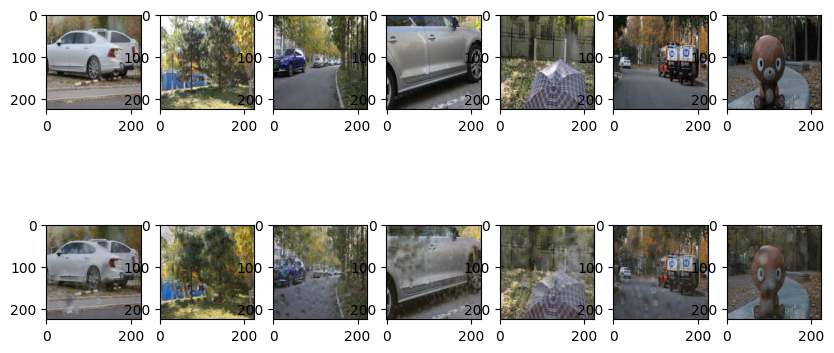

In [23]:
for batch in train_dl:
    batch_rain, batch_GT = batch['img_rain'], batch['img_GT'].to('cpu')
    
    preds = model2(batch_rain)
    preds = preds.detach().to('cpu')
    
    batch_GT = denormalize(batch_GT, *stats)
#     batch_rain = denormalize(batch_rain, *stats)
    preds = denormalize(preds, *stats)
    
    f, axarr = plt.subplots(2,7, figsize = (10,5))
    for i in range(7):
        axarr[0,i].imshow(batch_GT[i].permute(1,2,0))
        axarr[1,i].imshow(preds[i].permute(1,2,0))
#     f.tickparams(left = False, bottom = False)
    break